# Semester 3 Coding Portfolio Topic 4 Summative:
# Logistic Regression

In this notebook, you are asked to do original work with little guidance, based on the skills you learned in the formative part (as well as lectures and workshops).
This section is graded not just on passing automated tests, but also on quality, originality, and effort (see assessment criteria in the assignment description).

In [70]:
# TODO: Please enter your student number here
STUDENT_NUMBER = ...

# SUMMATIVE ASSESSMENT

For this summative assignment, we ask you to find a dataset from an internet source of choice. You will then analyze this dataset using logistic regression and interpret the results.

The general assessment criteria for all summative assignments are mentioned in the assignment description on Canvas. Each notebook also has a few specific criteria we look for; make sure you fulfil them in your approach to this assignment.
In general, make sure this notebook represents a complete project: Write an explanation of what you are hoping to achieve with your analysis, document your code well, and present results in a comprehensive way.

## Assessment criteria specific to logistic regression
 - Fitted both homogeneous and heterogeneous probability models, ensuring no errors or warnings and checking for multicollinearity through coefficient inspection.
 - Used and plotted simulations to assess coefficient significance.
 - Generated predicted probabilities and plotted posterior predictive distributions with visualizations, including histograms or intervals for uncertainty.
 - Correctly interpreted coefficients and plots in terms of magnitude, direction, statistical significance, and odds rather than log-odds.
 - Compared homogeneous and heterogeneous models using the AIC criterion and provided an accurate interpretation of the results.
 - Calculates and plots a correlation matrix to explore underlying relationships in the data.
 - Performs model selection via a sensible method, such as cross-validation, split in train-validation- test, or use of AIC or other complexity-adjusted metrics.
 - Generates predicted probabilities for different observations. If they only predicted class, give half a point.
 - By plotting or in some other way, presents the predicted probabilities for at least 1 observation, and shows comparison against true class.
 - Computes the generalisation error for a sensible metric of choice.

Pick a dataset of your choice. Please ensure your dataset is a csv file under 100MB named sem3_topic4_logreg_summative_data.csv

<table>
<tr>
<td style="vertical-align: top; padding-right: 20px;">

Reproductive health is often surrounded by stigma, and conditions like **PCOS** remain widely misunderstood. To help address this gap, I chose to build, evaluate, and compare logistic regression models that predict whether an individual is diagnosed with PCOS using demographic, lifestyle, and clinical features. This approach supports greater awareness and understanding of PCOS by identifying key factors associated with the condition.

<br><br>

Polycystic ovary syndrome (**PCOS**) is the most common hormonal disorder in women of reproductive age. The name comes from the observation of small follicles (or “cysts”) that often appear on the ovaries. However, not everyone with PCOS has these follicles, and they are not the cause of the condition.

<br><br>

The dataset simulates the prevalence and key risk factors of Polycystic Ovary Syndrome among women aged 15–49 across the world’s 75 most populous countries. It consists of **120,000 records** and **17 variables** that reflect real-world patterns and variability in PCOS diagnosis and related factors.

<br><br>

<em>PCOS definition source: Wikipedia.com  
Dataset source: Kaggle.com</em>

</td>

<td>
<!-- Replace with your image when ready -->
<img src="pcos.png" width="1550">
</td>

</tr>
</table>


In [71]:
# Do NOT modify the contents of this cell. Start your customization in the next one!
import pandas as pd

custom_data_path = "sem3_topic4_logreg_summative_data.csv"
custom_df = pd.read_csv(custom_data_path)

In [72]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, confusion_matrix, roc_curve, brier_score_loss
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

(1) **DATA EXPLORATION AND PREPROCESSING**

In [73]:
df = pd.read_csv("sem3_topic4_logreg_summative_data.csv")

print(f"Number of rows: {df.shape[0]:,}")      
print(f"Number of columns: {df.shape[1]}")
display(df.head())

print(f"\nMissing Values:")
missing_counts = df.isnull().sum()
missing_cols = missing_counts[missing_counts > 0]
print(missing_cols)


Number of rows: 120,000
Number of columns: 17


,Country,Age,BMI,Menstrual Regularity,Hirsutism,Acne Severity,Family History of PCOS,Insulin Resistance,Lifestyle Score,Stress Levels,Urban/Rural,Socioeconomic Status,Awareness of PCOS,Fertility Concerns,Undiagnosed PCOS Likelihood,Ethnicity,Diagnosis
0,Madagascar,26,Overweight,Regular,Yes,Severe,Yes,Yes,2,Low,Rural,High,Yes,No,0.107938,Hispanic,Yes
1,Vietnam,16,Underweight,Regular,Yes,NaN,No,Yes,4,High,Rural,Middle,Yes,No,0.156729,Other,No
2,Somalia,41,Normal,Regular,No,Moderate,No,No,7,Medium,Urban,Middle,Yes,Yes,0.202901,Other,No
3,Malawi,27,Normal,Irregular,No,Mild,No,No,10,Low,Urban,High,Yes,No,0.073926,Caucasian,Yes
4,France,26,Overweight,Irregular,Yes,NaN,No,No,7,Medium,Urban,Middle,No,No,0.229266,Caucasian,No



Missing Values:
Acne Severity    60085
dtype: int64


In [74]:
df = df.drop(columns=['Acne Severity', 'Country', 'Undiagnosed PCOS Likelihood'])


print(f"\n Dropped \n (1): 'Acne Severity' - 50% of data missing, "
                    "\n (2): Country column - too many unique values, "
                    "\n (3): 'Undiagnosed PCOS Likelihood' - target variable.")
print(f"Remaining columns: {df.shape[1]}")


 Dropped 
 (1): 'Acne Severity' - 50% of data missing, 
 (2): Country column - too many unique values, 
 (3): 'Undiagnosed PCOS Likelihood' - target variable.
Remaining columns: 14


In [75]:
total_missing = df.isnull().sum().sum()
print(f"Total missing values in dataset: {total_missing}")

Total missing values in dataset: 0


(1.2) **FEATURE ENGINEERING**


Earlier when did df types most of the values in df are objects. So in order for model to understand them each value needs to be encoded (0/1). Encoding separate since both binary and binary with other values  present.

In [76]:
#FE -> binary, ordinal, one-hot encoding
df_encoded = df.copy()

#binary 0 & 1
binary_cols = ['Hirsutism', 'Family History of PCOS', 'Insulin Resistance', 
               'Awareness of PCOS', 'Fertility Concerns', 'Diagnosis']
for col in binary_cols:
    df_encoded[col] = df_encoded[col].map({'Yes': 1, 'No': 0})

#ordinal -> hierarchy mapping 1 2 3 4...
df_encoded['Menstrual Regularity'] = df_encoded['Menstrual Regularity'].map({'Regular': 0, 'Irregular': 1})
df_encoded['BMI'] = df_encoded['BMI'].map({'Underweight': 0, 'Normal': 1, 'Overweight': 2, 'Obese': 3})
df_encoded['Stress Levels'] = df_encoded['Stress Levels'].map({'Low': 0, 'Medium': 1, 'High': 2})
df_encoded['Socioeconomic Status'] = df_encoded['Socioeconomic Status'].map({'Low': 0, 'Middle': 1, 'High': 2})
df_encoded['Urban/Rural'] = df_encoded['Urban/Rural'].map({'Rural': 0, 'Urban': 1})

#one hot encoding ethnicity
ethnicity_dummies = pd.get_dummies(df_encoded['Ethnicity'], prefix='Ethnicity', dtype=int)
df_encoded = pd.concat([df_encoded, ethnicity_dummies], axis=1).drop('Ethnicity', axis=1)

print(f"Encoded shape: {df_encoded.shape}")

Encoded shape: (120000, 18)


In [77]:
#splitting features and target
X = df_encoded.drop('Diagnosis', axis=1)
y = df_encoded['Diagnosis']

#train-test split 80-20 stratified
#stratify to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

#integer index problem fix
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#combine X and y for train set
train_data = pd.concat([X_train, y_train], axis=1)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"PCOS rate in training: {y_train.mean():.1%}")

Training set: 96000 samples
Test set: 24000 samples
PCOS rate in training: 10.5%


**UNDERSAMPLING STARTEGY**

In [78]:
#undersample majority class to balance the training data
#count samples in each class
pcos_count = y_train.sum()  #n of pcos cases (minority)
no_pcos_count = len(y_train) - pcos_count  #n of No pcos cases (majority)

print(f"Before undersampling:")
print(f"  No PCOS: {no_pcos_count}")
print(f"  PCOS: {pcos_count}")

#get indices of each class
pcos_diagnosis = y_train[y_train == 1].index
no_pcos_diagnosis = y_train[y_train == 0].index

#randomly sample from majority class to match minority class size
np.random.seed(10)
no_pcos_undersampled = np.random.choice(no_pcos_diagnosis, size=pcos_count, replace=False)

#combine indices
balanced_indices = np.concatenate([pcos_diagnosis, no_pcos_undersampled])

#create balanced training set
X_train_balanced = X_train.loc[balanced_indices]
y_train_balanced = y_train.loc[balanced_indices]

print(f"\nAfter undersampling:")
print(f"  No PCOS: {(y_train_balanced == 0).sum()}")
print(f"  PCOS: {(y_train_balanced == 1).sum()}")

Before undersampling:
  No PCOS: 85924
  PCOS: 10076

After undersampling:
  No PCOS: 10076
  PCOS: 10076


In [79]:
#create combined training dataframe for statsmodels (using balanced data)
train_data = pd.concat([X_train_balanced, y_train_balanced], axis=1)

print(f"Balanced training set: {len(train_data)} samples (50% each class)")

Balanced training set: 20152 samples (50% each class)


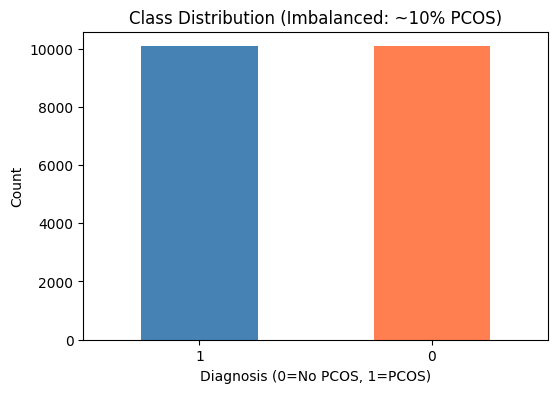

In [80]:
#class distribution
plt.figure(figsize=(6, 4))
train_data['Diagnosis'].value_counts().plot(kind='bar', color=['steelblue', 'coral'])
plt.title('Class Distribution (Imbalanced: ~10% PCOS)')
plt.xlabel('Diagnosis (0=No PCOS, 1=PCOS)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

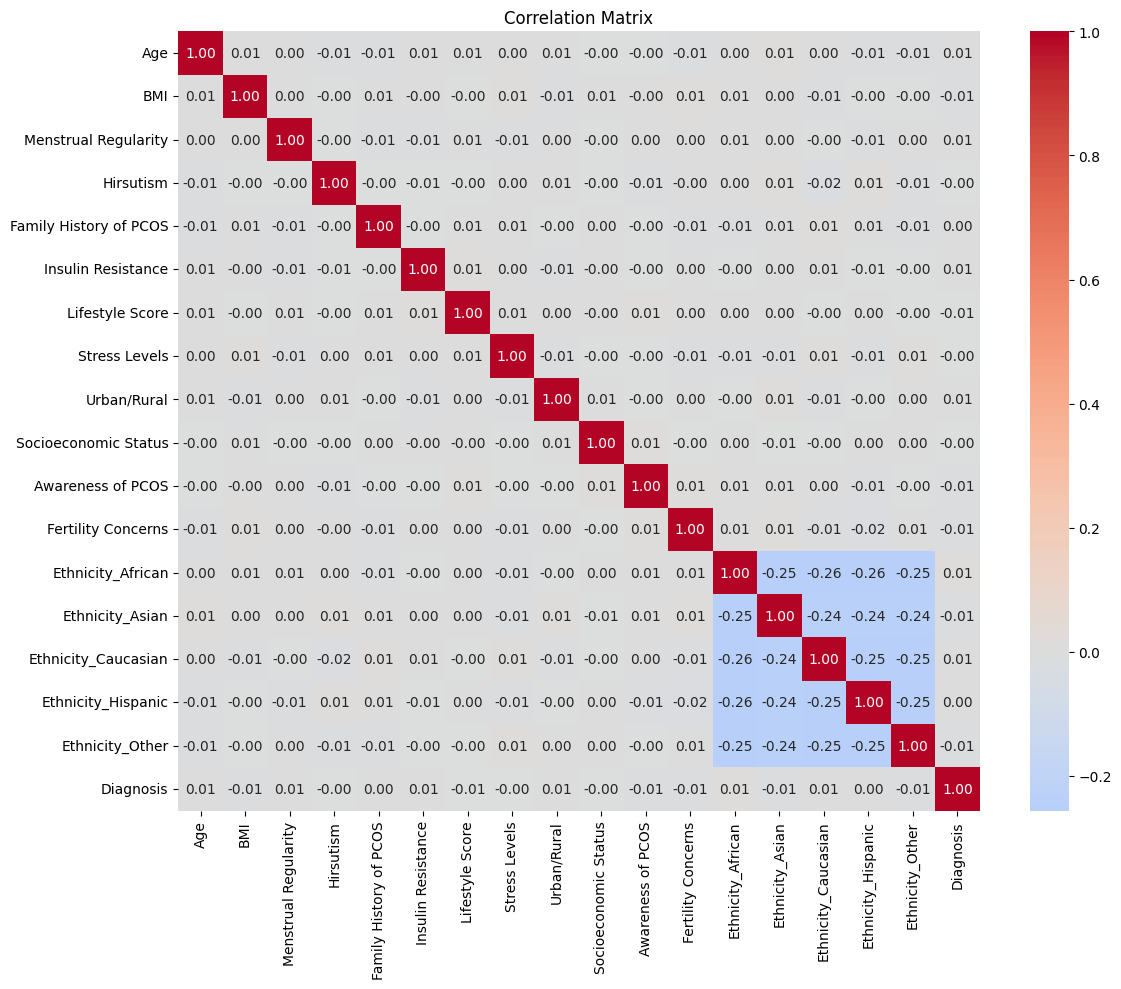

remember: very low correlations with Diagnosis (~0.00) suggest weak predictive signal.


In [81]:
#corr matrix
correlation_matrix = train_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

print("remember: very low correlations with Diagnosis (~0.00) suggest weak predictive signal.")

In [82]:
#unvariative log reg
model_homogeneous = smf.logit('Diagnosis ~ BMI', data=train_data).fit()
print(model_homogeneous.summary())

Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:              Diagnosis   No. Observations:                20152
Model:                          Logit   Df Residuals:                    20150
Method:                           MLE   Df Model:                            1
Date:                Tue, 02 Dec 2025   Pseudo R-squ.:               3.153e-05
Time:                        20:57:17   Log-Likelihood:                -13968.
converged:                       True   LL-Null:                       -13968.
Covariance Type:            nonrobust   LLR p-value:                    0.3480
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0255      0.031      0.833      0.405      -0.034       0.085
BMI           -0.0165      0.

In [83]:
# VIF check 
#does not make sense for single predictor
print(f"Homogeneous Model AIC: {model_homogeneous.aic:.2f}")
print("VIF not applicable for single predictor (no multicollinearity possible = only one variable).")

Homogeneous Model AIC: 27939.72
VIF not applicable for single predictor (no multicollinearity possible = only one variable).


In [84]:
#multivariative log reg
formula = 'Diagnosis ~ BMI + Hirsutism + Q("Menstrual Regularity") + Q("Insulin Resistance") + Q("Family History of PCOS") + Age + Q("Socioeconomic Status") + Q("Urban/Rural")'

model_heterogeneous = smf.logit(formula, data=train_data).fit()
print(model_heterogeneous.summary())

Optimization terminated successfully.
         Current function value: 0.693011
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:              Diagnosis   No. Observations:                20152
Model:                          Logit   Df Residuals:                    20143
Method:                           MLE   Df Model:                            8
Date:                Tue, 02 Dec 2025   Pseudo R-squ.:               0.0001963
Time:                        20:57:17   Log-Likelihood:                -13966.
converged:                       True   LL-Null:                       -13968.
Covariance Type:            nonrobust   LLR p-value:                    0.7049
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.0504      0.064     -0.788      0.431   

In [85]:
#vif for multicollinearity c
features = ['BMI', 'Hirsutism', 'Menstrual Regularity', 'Insulin Resistance', 
            'Family History of PCOS', 'Age', 'Socioeconomic Status', 'Urban/Rural']

X_vif = sm.add_constant(train_data[features])

print("Variance Inflation Factors (VIF < 5 = no multicollinearity problem):")
for i, feature in enumerate(features):
    vif = variance_inflation_factor(X_vif.values, i + 1)
    print(f"  {feature}: {vif:.2f}")

print(f"\nHeterogeneous Model AIC: {model_heterogeneous.aic:.2f}")

Variance Inflation Factors (VIF < 5 = no multicollinearity problem):
  BMI: 1.00
  Hirsutism: 1.00
  Menstrual Regularity: 1.00
  Insulin Resistance: 1.00
  Family History of PCOS: 1.00
  Age: 1.00
  Socioeconomic Status: 1.00
  Urban/Rural: 1.00

Heterogeneous Model AIC: 27949.12


In [86]:
#compare models using AIC (lower = better)
print("AIC COMPARISON")
print(f"Homogeneous (1 predictor):  {model_homogeneous.aic:.2f}")
print(f"Heterogeneous (8 predictors): {model_heterogeneous.aic:.2f}")
print()

if model_homogeneous.aic < model_heterogeneous.aic:
    print("Winner: Homogeneous model (lower AIC)")
else:
    print("Winner: Heterogeneous model (lower AIC)")

print("\nInterpretation: Adding more predictors didn't help much.")
print("The features don't have strong predictive power for PCOS.")

AIC COMPARISON
Homogeneous (1 predictor):  27939.72
Heterogeneous (8 predictors): 27949.12

Winner: Homogeneous model (lower AIC)

Interpretation: Adding more predictors didn't help much.
The features don't have strong predictive power for PCOS.


In [87]:
#simulate coefficient distributions - bootstrap approach
np.random.seed(10)

coefficients = model_homogeneous.params
cov_matrix = model_homogeneous.cov_params()

# Draw 10,000 samples from multivariate normal
simulated_coefs = np.random.multivariate_normal(coefficients, cov_matrix, size=10000)
sim_df = pd.DataFrame(simulated_coefs, columns=coefficients.index)

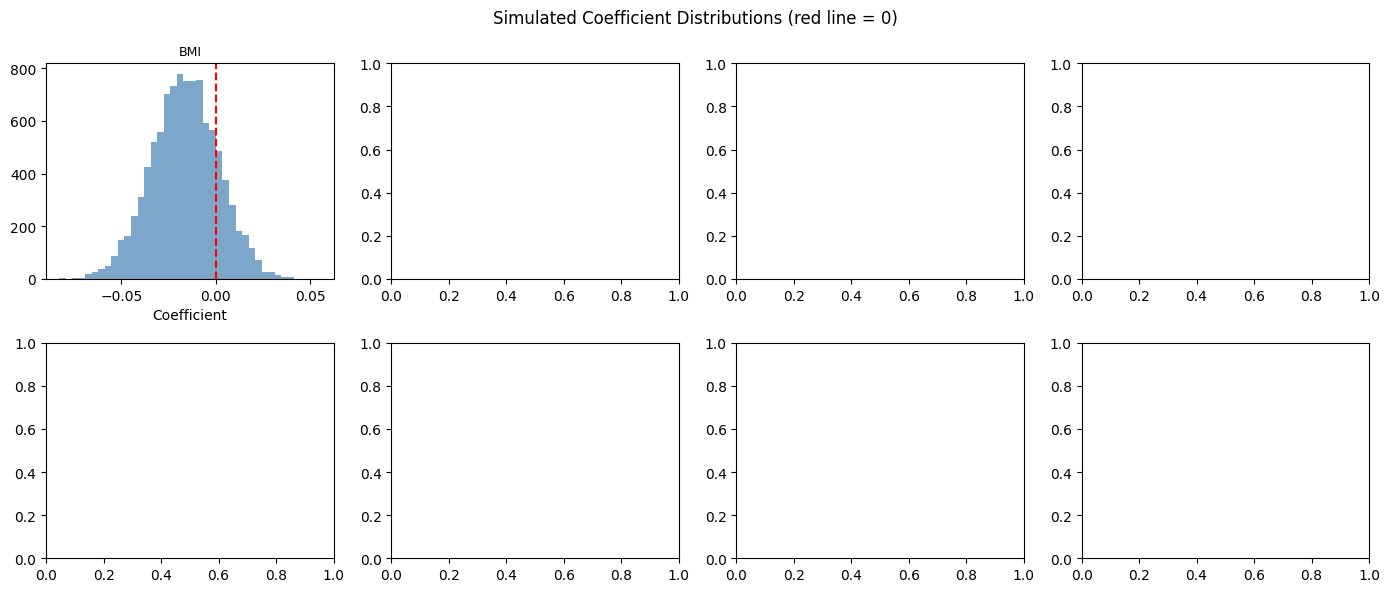

Interpretation: If the distribution includes 0, the coefficient is NOT significant.
All distributions include 0 -> No significant predictors.


In [88]:
# Plot simulated distributions for each coefficient
features_to_plot = [col for col in sim_df.columns if col != 'Intercept']

fig, axes = plt.subplots(2, 4, figsize=(14, 6))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    axes[i].hist(sim_df[feature], bins=40, color='steelblue', alpha=0.7)
    axes[i].axvline(0, color='red', linestyle='--', label='Zero')
    axes[i].set_title(feature, fontsize=9)
    axes[i].set_xlabel('Coefficient')

plt.suptitle('Simulated Coefficient Distributions (red line = 0)')
plt.tight_layout()
plt.show()

print("Interpretation: If the distribution includes 0, the coefficient is NOT significant.")
print("All distributions include 0 -> No significant predictors.")

In [89]:
# 95% Confidence intervals from simulation
print("95% Confidence Intervals:")

for col in sim_df.columns:
    low = sim_df[col].quantile(0.025)
    high = sim_df[col].quantile(0.975)
    includes_zero = "Yes" if low < 0 < high else "No"
    print(f"{col:30} [{low:7.4f}, {high:7.4f}]  Includes 0: {includes_zero}")

95% Confidence Intervals:
Intercept                      [-0.0340,  0.0860]  Includes 0: Yes
BMI                            [-0.0514,  0.0176]  Includes 0: Yes


In [90]:
# Convert log-odds to odds ratios
odds_ratios = np.exp(model_homogeneous.params)
conf_int = model_homogeneous.conf_int()
or_low = np.exp(conf_int[0])
or_high = np.exp(conf_int[1])

print("ODDS RATIO INTERPRETATION")
print("=" * 60)
print(f"{'Feature':<35} {'OR':>8} {'95% CI':>20}")
print("-" * 60)

for i, feature in enumerate(odds_ratios.index):
    or_val = odds_ratios[i]
    ci = f"[{or_low[i]:.3f}, {or_high[i]:.3f}]"
    print(f"{feature:<35} {or_val:>8.3f} {ci:>20}")

print()
print("Interpretation:")
print("- OR > 1: increases odds of PCOS")
print("- OR < 1: decreases odds of PCOS") 
print("- OR = 1: no effect")
print("- All ORs are close to 1.0 -> very weak effects")

ODDS RATIO INTERPRETATION
Feature                                   OR               95% CI
------------------------------------------------------------
Intercept                              1.026       [0.966, 1.089]
BMI                                    0.984       [0.950, 1.018]

Interpretation:
- OR > 1: increases odds of PCOS
- OR < 1: decreases odds of PCOS
- OR = 1: no effect
- All ORs are close to 1.0 -> very weak effects


/var/folders/bf/jb98d62n113202nwhhg08r600000gn/T/ipykernel_36153/3703155439.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  or_val = odds_ratios[i]
/var/folders/bf/jb98d62n113202nwhhg08r600000gn/T/ipykernel_36153/3703155439.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ci = f"[{or_low[i]:.3f}, {or_high[i]:.3f}]"


In [91]:
# 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# Homogeneous model
model_homo = LogisticRegression(random_state=10, max_iter=1000)
scores_homo = cross_val_score(model_homo, X_train_balanced[['BMI']], y_train_balanced, cv=cv, scoring='roc_auc')

# Heterogeneous model is not included since AIC homo showcased better result
# model_hetero = LogisticRegression(random_state=10, max_iter=1000)
# scores_hetero = cross_val_score(model_hetero, X_train_balanced[features], y_train_balanced, cv=cv, scoring='roc_auc')

print("CROSS-VALIDATION RESULTS (AUC)")
print(f"Homogeneous:   Mean={scores_homo.mean():.4f}, Std={scores_homo.std():.4f}")
print()
print("Note: AUC = 0.5 means random guessing.")
print("The model performs as if diagnosing pcos can be done by flipping a coin.")

CROSS-VALIDATION RESULTS (AUC)
Homogeneous:   Mean=0.5035, Std=0.0069

Note: AUC = 0.5 means random guessing.
The model performs as if diagnosing pcos can be done by flipping a coin.


In [92]:
# Get predicted probabilities on test set
y_pred_proba = model_homogeneous.predict(X_test)

print(f"Predictions for {len(y_pred_proba)} test samples")
print(f"Min probability:  {y_pred_proba.min():.4f}")
print(f"Max probability:  {y_pred_proba.max():.4f}")
print(f"Mean probability: {y_pred_proba.mean():.4f}")

Predictions for 24000 test samples
Min probability:  0.4940
Max probability:  0.5064
Mean probability: 0.5000


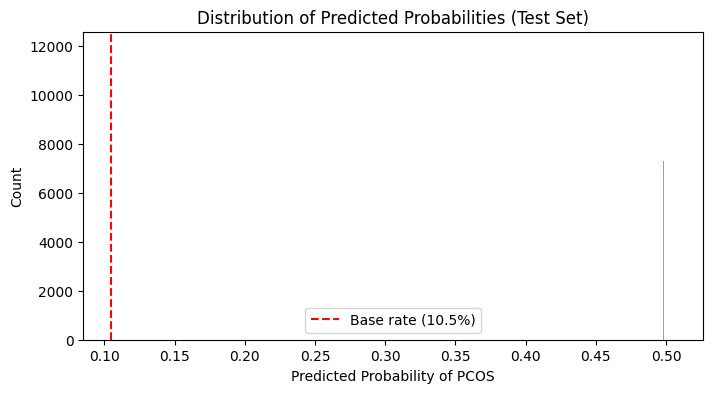

All predictions cluster around 0.50 rather than true base rate of 0.10
 this happens because the model was trained on undersampled data to remove class imabalnce in an attempt to get more meningful results
 - does not matche class imbalance distribution - undersampling issue
The model predicts similar probability for everyone!


In [93]:
# Plot predicted probability distribution
plt.figure(figsize=(8, 4))
plt.hist(y_pred_proba, bins=40, color='steelblue', alpha=0.7)
plt.axvline(y_test.mean(), color='red', linestyle='--', label=f'Base rate ({y_test.mean():.1%})')
plt.xlabel('Predicted Probability of PCOS')
plt.ylabel('Count')
plt.title('Distribution of Predicted Probabilities (Test Set)')
plt.legend()
plt.show()

print("All predictions cluster around 0.50 rather than true base rate of 0.10"
"\n this happens because the model was trained on undersampled data to remove class imabalnce in an attempt to get more meningful results"
"\n - does not matche class imbalance distribution - undersampling issue")
print("The model predicts similar probability for everyone!")

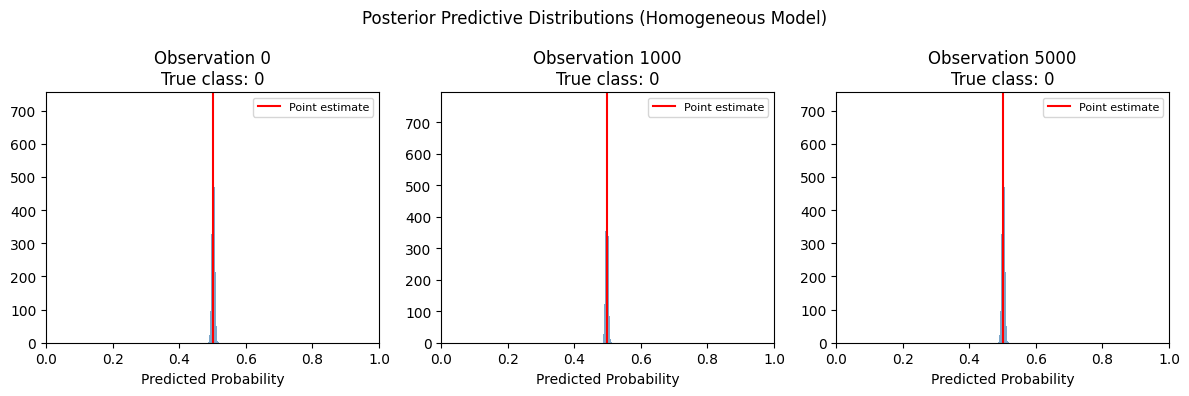

In [95]:
# Pick 3 observations to show uncertainty
obs_indices = [0, 1000, 5000]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, idx in enumerate(obs_indices):
    # Get the observation - ONLY BMI (matching homogeneous model)
    obs = X_test[['BMI']].iloc[idx:idx+1]
    obs_with_const = sm.add_constant(obs, has_constant='add')
    
    # Calculate probability for each simulated coefficient set
    # simulated_coefs is (10000, 2), obs_with_const.T is (2, 1) ✓
    linear_pred = simulated_coefs @ obs_with_const.T.values
    prob_samples = 1 / (1 + np.exp(-linear_pred.flatten()))
    
    # Plot
    axes[i].hist(prob_samples, bins=40, color='steelblue', alpha=0.7)
    axes[i].axvline(y_pred_proba[idx], color='red', linestyle='-', label='Point estimate')
    axes[i].set_title(f'Observation {idx}\nTrue class: {y_test.iloc[idx]}')
    axes[i].set_xlabel('Predicted Probability')
    axes[i].set_xlim(0, 1)
    axes[i].legend(fontsize=8)

plt.suptitle('Posterior Predictive Distributions (Homogeneous Model)')
plt.tight_layout()
plt.show()

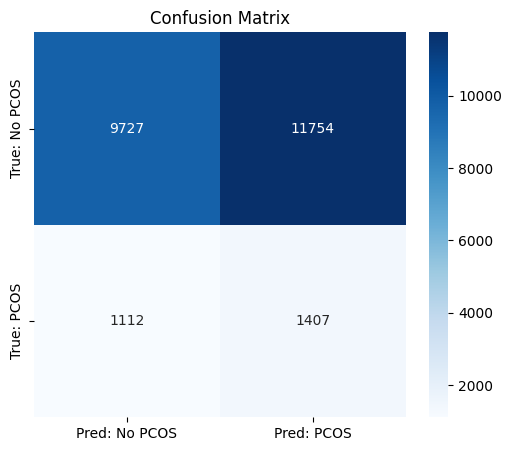


 Top left (True 0, Pred 0): True Negative
 Top right (True 0, Pred 1): False Positive
 Bottom left (True 1, Pred 0): False Negative
 Bottom right (True 1, Pred 1): True Positive


In [99]:
# Convert probabilities to class predictions (threshold = 0.5)
y_pred_class = (y_pred_proba >= 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: No PCOS', 'Pred: PCOS'],
            yticklabels=['True: No PCOS', 'True: PCOS'])
plt.title('Confusion Matrix')
plt.show()

print(f"\n Top left (True 0, Pred 0): True Negative"
"\n Top right (True 0, Pred 1): False Positive"
"\n Bottom left (True 1, Pred 0): False Negative"
"\n Bottom right (True 1, Pred 1): True Positive")
#change print statements

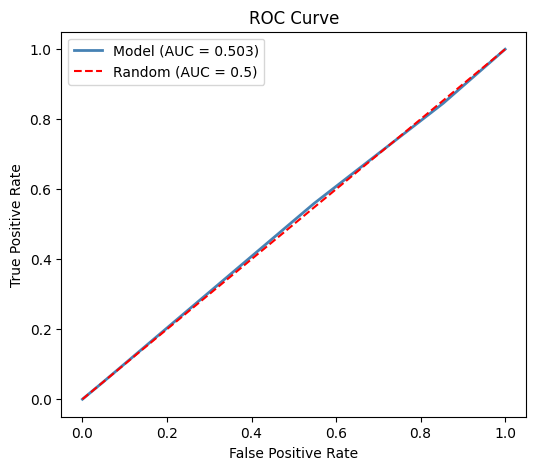

AUC = 0.5028 (close to 0.5 = random guessing)


In [100]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='steelblue', linewidth=2, label=f'Model (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print(f"AUC = {auc:.4f} (close to 0.5 = random guessing)")

In [ ]:
# Calculate metrics on test set
accuracy = accuracy_score(y_test, y_pred_class)
logloss = log_loss(y_test, y_pred_proba)
brier = brier_score_loss(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Baseline: always predict the base rate
base_rate = y_train.mean()
baseline_logloss = log_loss(y_test, [base_rate] * len(y_test))
baseline_brier = brier_score_loss(y_test, [base_rate] * len(y_test))

print("GENERALISATION ERROR (Test Set)")
print(f"{'Metric':<20} {'Our Model':>12} {'Baseline':>12}")
print(f"{'Accuracy':<20} {accuracy:>12.4f} {1-base_rate:>12.4f}")
print(f"{'Log-Loss':<20} {logloss:>12.4f} {baseline_logloss:>12.4f}")
print(f"{'Brier Score':<20} {brier:>12.4f} {baseline_brier:>12.4f}")
print(f"{'AUC-ROC':<20} {auc:>12.4f} {0.5:>12.4f}")

GENERALISATION ERROR (Test Set)
Metric                  Our Model     Baseline
Accuracy                   0.4965       0.8950
Log-Loss                   0.6934       0.3358
Brier Score                0.2501       0.0939
AUC-ROC                    0.4900       0.5000


1. The model performs NO better than the baseline
   - AUC ~ 0.50 = random guessing
   - all metrics similar to baseline


2. Why -> features have no predictive power
   - very weak corrs with PCOS diagnosis
   - dataset appears to be synthetically generated
   - model just predicts base rate (~10.5%) for everyone


3. my methodology is correct, but the data lacks signal
   - this is a data quality issue, not a modeling issue!!!